In [17]:
import polars as pl
import matplotlib.pyplot as plt

df = pl.read_csv("lalonde.txt", has_header=True, separator=",")

df.head(5)

treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
i64,i64,i64,i64,i64,i64,i64,f64,f64,f64
0,45,11,0,0,1,1,21516.67,25243.55,25564.67
0,21,14,0,0,0,0,3175.971,5852.565,13496.08
0,38,12,0,0,1,0,23039.02,25130.76,25564.67
0,48,6,0,0,1,1,24994.37,25243.55,25564.67
0,18,8,0,0,1,1,1669.295,10727.61,9860.869


In [18]:
# Get the descriptive statistics as a pandas DataFrame
df_describe = df.describe().to_pandas()

# Save the descriptive statistics as a LaTeX table
with open("summary_stats.tex", "w") as f:
    f.write("\\begin{center}\n")
    f.write("\\begin{tabular}{l" + "c" * len(df_describe.columns) + "}\n")
    f.write("\\hline\n")
    f.write(" & " + " & ".join(df_describe.columns) + " \\\\\n")
    f.write("\\hline\n")
    for index, row in df_describe.iterrows():
        f.write(f"{index} & " + " & ".join(f"{value:.4f}" if isinstance(value, (int, float)) else str(value) for value in row) + " \\\\\n")
    f.write("\\hline\n")
    f.write("\\end{tabular}\n")
    f.write("\\end{center}\n")

In [19]:
import statsmodels.api as sm

# Convert Polars DataFrame to pandas DataFrame for statsmodels
df_pd = df.select(['re75', 're78']).to_pandas()

X = df_pd['re75']
y = df_pd['re78']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

# Save a simple version of the regression model in LaTeX
# Extract intercept and coefficient with their standard errors
params = model.params
bse = model.bse

with open("model_simple.tex", "w") as f:
    f.write("\\begin{center}\n")
    f.write("\\begin{tabular}{lcc}\n")
    f.write("\\hline\n")
    f.write(" & Coefficient & Std. Error \\\\\n")
    f.write("\\hline\n")
    f.write(f"Intercept & {params['const']:.4f} & {bse['const']:.4f} \\\\\n")
    f.write(f"re75 & {params['re75']:.4f} & {bse['re75']:.4f} \\\\\n")
    f.write("\\hline\n")
    f.write("\\end{tabular}\n")
    f.write("\\end{center}\n")

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                 1.291e+04
Date:                Tue, 11 Nov 2025   Prob (F-statistic):               0.00
Time:                        10:51:01   Log-Likelihood:            -1.6468e+05
No. Observations:               15992   AIC:                         3.294e+05
Df Residuals:                   15990   BIC:                         3.294e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5352.7055    101.018     52.988      0.0

In [20]:
N = df_pd.shape[0]

mean = df_pd['re75'].mean()

squared_diffs = (df_pd['re75'] - mean) ** 2

# Use with_columns to add the leverage column
import numpy as np

leverage_values = (1/N) + squared_diffs.to_numpy() / squared_diffs.sum()
df_leverage = df.with_columns(
	pl.Series('leverage', leverage_values)
)

# Select rows where leverage > 3/N using filter
df_high_leverage = df_leverage.filter(pl.col('leverage') > 3/N)

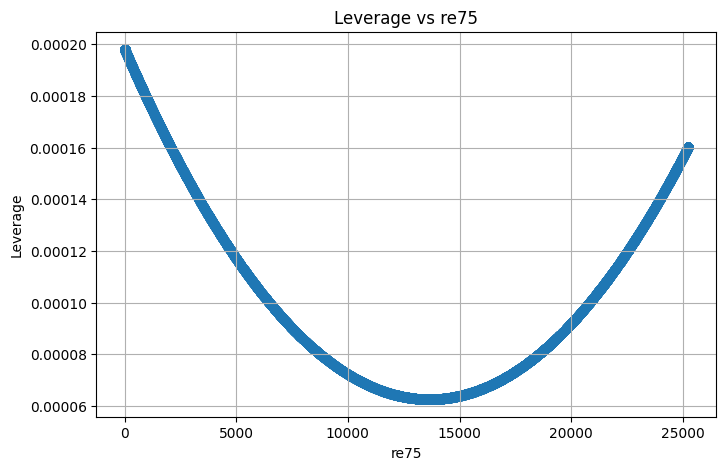

In [21]:
plt.figure(figsize=(8, 5))
plt.scatter(df_leverage['re75'].to_numpy(), df_leverage['leverage'].to_numpy(), alpha=0.7)
plt.title('Leverage vs re75')
plt.xlabel('re75')
plt.ylabel('Leverage')
plt.grid(True)
plt.savefig('leverage_plot.png')
plt.show()

In [22]:
# Select all columns except 're78' and 'treat' as predictors
predictor_cols = ['age', 'education', 'black', 'hispanic', 're74', 're75']
X_all = df.select(predictor_cols).to_pandas()
y_all = df['re78'].to_numpy()

# Add constant for intercept
X_all = sm.add_constant(X_all)

# Fit OLS regression
model_all = sm.OLS(y_all, X_all).fit()
print(model_all.summary())

# Save all coefficients and their standard errors in LaTeX
params_all = model_all.params
bse_all = model_all.bse

with open("model_all.tex", "w") as f:
    f.write("\\begin{center}\n")
    f.write("\\begin{tabular}{lcc}\n")
    f.write("\\hline\n")
    f.write(" & Coefficient & Std. Error \\\\\n")
    f.write("\\hline\n")
    for param in params_all.index:
        f.write(f"{param} & {params_all[param]:.4f} & {bse_all[param]:.4f} \\\\\n")
    f.write("\\hline\n")
    f.write("\\end{tabular}\n")
    f.write("\\end{center}\n")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     2412.
Date:                Tue, 11 Nov 2025   Prob (F-statistic):               0.00
Time:                        10:51:02   Log-Likelihood:            -1.6425e+05
No. Observations:               15992   AIC:                         3.285e+05
Df Residuals:                   15985   BIC:                         3.286e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6461.5815    321.495     20.099      0.0

In [23]:
import numpy as np

# Calculate the hat matrix H = X(X'X)^{-1}X'
X_mat = X_all.values
XtX_inv = np.linalg.inv(X_mat.T @ X_mat)
H = X_mat @ XtX_inv @ X_mat.T

h_ii = np.diag(H)

df_with_leverages = df.with_columns(pl.Series('h_ii', h_ii).alias('leverage'))
# Get the top 5 rows in df_with_leverages by h_ii
df_with_leverages_top5 = df_with_leverages.sort('leverage', descending=True).head(5)
df_with_leverages_top5


treat,age,education,black,hispanic,married,nodegree,re74,re75,re78,leverage
i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64
0,29,18,1,0,0,0,0.0,25243.55,25564.67,0.002982
0,38,12,0,1,1,0,0.0,25243.55,25564.67,0.002717
0,28,12,0,1,1,0,25862.32,1090.306,21777.26,0.002641
0,52,18,0,0,1,0,0.0,25243.55,25564.67,0.002589
0,51,18,0,0,1,0,0.0,25241.76,23052.53,0.002552


In [24]:
# Calculate the threshold 3*6/N
threshold = 3 * 6 / N

# Count number of rows in df_with_leverages with leverage > threshold
num_high_leverage = df_with_leverages.filter(pl.col('leverage') > threshold).height
print(f"Number of rows with leverage > 3*6/N: {num_high_leverage}")

Number of rows with leverage > 3*6/N: 968


In [25]:
# Get residuals from the model
residuals = model_all.resid

# Standardize residuals
std_resid = abs(residuals / residuals.std())

df_with_residuals = df_with_leverages.with_columns(pl.Series('std_residuals', std_resid))
df_with_residuals.sort('std_residuals', descending=True).head(5)


treat,age,education,black,hispanic,married,nodegree,re74,re75,re78,leverage,std_residuals
i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64
0,29,18,0,0,1,0,25862.32,25243.55,0.0,0.00043,3.568122
0,24,12,0,0,1,0,25862.32,25243.55,0.0,0.00032,3.543759
0,25,13,0,0,0,0,25713.42,25243.55,19.21045,0.000285,3.536417
0,29,16,0,0,1,0,25862.32,25243.55,0.0,0.000299,3.535523
0,26,13,0,0,1,0,25862.32,25243.55,0.0,0.000271,3.530685


In [26]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

# Leave-One-Out Cross-Validation for simple model (re75 -> re78)
loo = LeaveOneOut()
squared_errors_simple = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model_cv = sm.OLS(y_train, X_train).fit()
    y_pred = model_cv.predict(X_test)
    squared_errors_simple.append((y_test.values[0] - y_pred.values[0])**2)

RMSE_simple_cv = np.sqrt(np.mean(squared_errors_simple))
print(f"LOOCV RMSE for simple model: {RMSE_simple_cv:.4f}")

# Leave-One-Out Cross-Validation for full model
squared_errors_full = []

for train_idx, test_idx in loo.split(X_all):
    X_train, X_test = X_all.iloc[train_idx], X_all.iloc[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]
    
    model_cv = sm.OLS(y_train, X_train).fit()
    y_pred = model_cv.predict(X_test)
    squared_errors_full.append((y_test[0] - y_pred.values[0])**2)

RMSE_full_cv = np.sqrt(np.mean(squared_errors_full))
print(f"LOOCV RMSE for full model: {RMSE_full_cv:.4f}")

LOOCV RMSE for simple model: 7177.1950
LOOCV RMSE for full model: 6991.9675
